## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Train

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from net import *
from utils import *
from custom_dataset import *

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2

##data
HOLDOUT_PERC = 0.90
TRAIN_BS = 128 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8

##training
N_EPOCHS = 40 #num of training epochs
OPTIMIZER = 'rmsprop' ##or adam
LRG = 0.004086800025392213 #learning rate generator
LRD = 0.013448070902660135 #learning rate discriminator
LRS_SZ = 5 #learning rate scheduler step size
LRS_GAMMA = 0.99 #learning rate scheduler gamma
BETAS = (0.5, 0.999) #momentum moving average
DROPOUT_PROB = 0.5 #dropout
WEIGHT_DECAY = 1e-5 #L2 Regularization
RUN_EXTRA_TIMES = 5 #iterate over validator extra times for every one time that the generator ates
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 128 #learned embeddings
N_LAYERS = 2 #num gru layers
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence
CLIP_VALUE = 0.008101987508250374 ##WGAN discriminator clip value for training stabalization

##inference
N_SAMPLES = 1000
MAX_LENGTH = 10

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 2 #how many epochs to output loss

##logging
RESULTS_PATH = '../results/'

In [3]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

def make_dir(path: str) -> None:
    '''
    Create results directory
    '''
    import shutil
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path)
    print('Created Folder at: ', path)

WRITEPATH = RESULTS_PATH + 'epoch_'+ str(N_EPOCHS) + '_exper_at_datetime_' + dt_string
make_dir(WRITEPATH)

Created Folder at:  ../results/epoch_40_exper_at_datetime_28-08-2024_16-31-01


#### Open SMILES Data

In [4]:
%%time

### Import the data
data_file = pd.read_csv('../data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

##split dset
train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
print('Len all smiles: ', len(smilesList))
print('Len train smiles: ', len(train_smiles))
print('Len holdout smiles: ', len(holdout_smiles))

print('\n')

Len all smiles:  249456
Len train smiles:  24945
Len holdout smiles:  224511


CPU times: user 211 ms, sys: 19.1 ms, total: 230 ms
Wall time: 238 ms


In [5]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('\n')



CPU times: user 595 ms, sys: 40.3 ms, total: 635 ms
Wall time: 634 ms


In [6]:
%%time

##define dataset
dataset = SMILESDataset(train_smiles, vocab, max_length)

##runs slightly faster using linux, because able to use num_workers > 0
if LINUX:
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True, prefetch_factor=PREFETCH_FACTOR, num_workers=NUM_WORKERS)
else:
    ##windows
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('max_length: ', max_length)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
max_length:  27


CPU times: user 222 µs, sys: 24 µs, total: 246 µs
Wall time: 245 µs


### Instantiate GAN and Discriminator Networks

In [7]:
%%time

##init networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                  num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

n_disc = Discriminator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                       num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

if MULTI_GPU:
    ##for multi-gpu
    n_gen = nn.DataParallel(n_gen)
    n_disc = nn.DataParallel(n_disc)

##set optimization
if OPTIMIZER == 'rmsprop':
    g_opt = torch.optim.RMSprop(n_gen.parameters(), lr=LRG, weight_decay=WEIGHT_DECAY)
    d_opt = torch.optim.RMSprop(n_disc.parameters(), lr=LRD, weight_decay=WEIGHT_DECAY)
else: 
    g_opt = optim.Adam(n_gen.parameters(), lr=LRG, betas=BETAS, weight_decay=WEIGHT_DECAY)
    d_opt = optim.Adam(n_disc.parameters(), lr=LRD, betas=BETAS, weight_decay=WEIGHT_DECAY)

##set schedulers
schedule_g = StepLR(g_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)
schedule_d = StepLR(d_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)

##init criterion
crit = nn.BCELoss()

print('\n')



CPU times: user 1.29 s, sys: 369 ms, total: 1.66 s
Wall time: 2.08 s


### Generator Network

In [8]:
print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))


Total generator param cnt:  8962624
Trainable generator param cnt:  8962624


In [9]:
n_gen

DataParallel(
  (module): Generator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (fc): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Descriminator Network

In [10]:
print('\nTotal discriminator param cnt: ', count_parameters(n_disc))
print('Trainable discriminator param cnt: ', count_trainable_parameters(n_disc))


Total discriminator param cnt:  8666945
Trainable discriminator param cnt:  8666945


In [11]:
n_disc

DataParallel(
  (module): Discriminator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (fc_reduce): Linear(in_features=256, out_features=128, bias=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Train GAN

In [12]:
%%time

hist, gnet, dnet =  train_gan(generator=n_gen, discriminator=n_disc, g_optimizer=g_opt, d_optimizer=d_opt, criterion=crit, 
                              g_schedule=schedule_g, d_schedule=schedule_d, data_loader=dataloader, run_extra_times=RUN_EXTRA_TIMES, 
                              clip_value=CLIP_VALUE, n_epochs=N_EPOCHS, multi_gpu=MULTI_GPU, device=DEVICE, print_loss_every=PRINT_LOSS_EVERY)

##save both networks
torch.save(gnet.state_dict(), WRITEPATH + '/gnet.pt')
torch.save(dnet.state_dict(), WRITEPATH + '/dnet.pt')

print('\n')

100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:39<00:00,  4.93it/s]


Epoch [0/40], D Loss: 1.37734, G Loss: 0.74505, Runtime/Epoch: 39.53100


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.43it/s]


Epoch [2/40], D Loss: 1.37667, G Loss: 0.68196, Runtime/Epoch: 35.89382


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.39it/s]


Epoch [4/40], D Loss: 1.37856, G Loss: 0.70084, Runtime/Epoch: 36.18911


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.44it/s]


Epoch [6/40], D Loss: 1.37802, G Loss: 0.72350, Runtime/Epoch: 35.83533


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.43it/s]


Epoch [8/40], D Loss: 1.37326, G Loss: 0.63728, Runtime/Epoch: 35.93829


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.31it/s]


Epoch [10/40], D Loss: 1.35717, G Loss: 0.84456, Runtime/Epoch: 36.74352


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:37<00:00,  5.20it/s]


Epoch [12/40], D Loss: 1.35393, G Loss: 0.59671, Runtime/Epoch: 37.46717


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:37<00:00,  5.23it/s]


Epoch [14/40], D Loss: 1.35883, G Loss: 0.58302, Runtime/Epoch: 37.29035


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:37<00:00,  5.20it/s]


Epoch [16/40], D Loss: 1.36950, G Loss: 0.57931, Runtime/Epoch: 37.52877


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.40it/s]


Epoch [18/40], D Loss: 1.37088, G Loss: 0.61763, Runtime/Epoch: 36.09653


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.33it/s]


Epoch [20/40], D Loss: 1.36639, G Loss: 0.60001, Runtime/Epoch: 36.56817


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:37<00:00,  5.24it/s]


Epoch [22/40], D Loss: 1.36413, G Loss: 0.58251, Runtime/Epoch: 37.18721


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.32it/s]


Epoch [24/40], D Loss: 1.37590, G Loss: 0.70907, Runtime/Epoch: 36.66165


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.33it/s]


Epoch [26/40], D Loss: 1.38434, G Loss: 0.65494, Runtime/Epoch: 36.60970


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.41it/s]


Epoch [28/40], D Loss: 1.35387, G Loss: 0.79299, Runtime/Epoch: 36.07015


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.42it/s]


Epoch [30/40], D Loss: 1.38269, G Loss: 0.62690, Runtime/Epoch: 35.97294


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.39it/s]


Epoch [32/40], D Loss: 1.36880, G Loss: 0.66913, Runtime/Epoch: 36.16658


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.35it/s]


Epoch [34/40], D Loss: 1.38131, G Loss: 0.63128, Runtime/Epoch: 36.47782


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.41it/s]


Epoch [36/40], D Loss: 1.37349, G Loss: 0.70372, Runtime/Epoch: 36.02337


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.43it/s]


Epoch [38/40], D Loss: 1.35104, G Loss: 0.76150, Runtime/Epoch: 35.92935


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.52it/s]



CPU times: user 28min 30s, sys: 4min 6s, total: 32min 36s
Wall time: 24min 21s


CPU times: user 153 ms, sys: 8.59 ms, total: 161 ms
Wall time: 166 ms


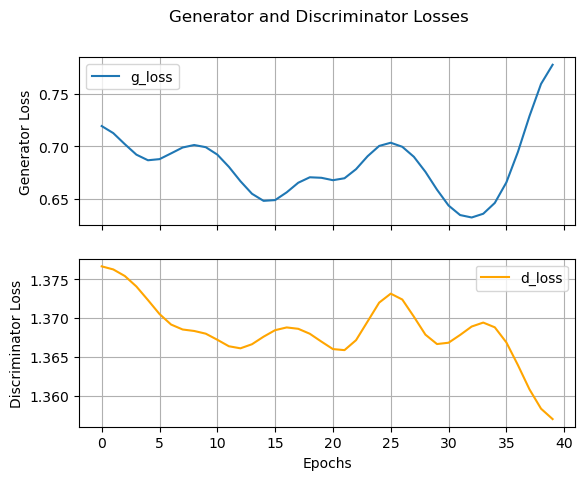

In [13]:
%%time

plot_losses(history=hist, sigma=SIGMA, save=True, savepath=WRITEPATH)

### Generate Molecules Using Trained GAN Generator 

In [26]:
%%time

gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=6, device=DEVICE)

print('\n')



CPU times: user 17.1 s, sys: 101 ms, total: 17.2 s
Wall time: 17.1 s


### Check Validity

In [27]:
%%capture

valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)

### Check Novelty

In [28]:
%%time

known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nChecking Novelty of Unique GAN Generated Samples')
novel_smiles = [] 
for smiles in list(set(valid_smiles)):
    can_smiles = canonicalize_smiles(smiles)
    if is_novel(can_smiles, known_can_smiles):
        novel_smiles.append(smiles)

print('\nNovel Cnt: ', len(novel_smiles))
print('\n----------------------Novel Smiles----------------------')
for i, smiles in enumerate(novel_smiles):
    print(f'\n{i}. {smiles}')
print('\n')


Len known canonical smiles:  249456

Checking Novelty of Unique GAN Generated Samples

Novel Cnt:  3

----------------------Novel Smiles----------------------

0. c2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1C

1. CC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)C

2. Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1


CPU times: user 185 ms, sys: 679 ms, total: 864 ms
Wall time: 4.45 s


### Check Solubility

In [29]:
%%time

aq_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_solubility, n_processors=N_PROCESSORS)
aq_scores_smilesList = MinMaxScaler().fit_transform(np.array(aq_scores_smilesList).reshape(-1, 1))
print('\nKnown Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(aq_scores_smilesList), 3))

GAN_aq_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_solubility, n_processors=N_PROCESSORS)
scaler = MinMaxScaler()
GAN_aq_scores_smilesList = scaler.fit_transform(np.array(GAN_aq_scores_smilesList).reshape(-1, 1))
print('\nGAN Generated Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(GAN_aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_aq_scores_smilesList), 3))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nGAN Generated Smiles Solubility Score (logS)')
logS_list = [estimate_solubility(i) for i in list(set(valid_smiles))]
logS = scaler.transform(np.array(logS_list).reshape(-1, 1))

for sol_score in logS:
    print('Solubility Score: ', np.round(sol_score.item(), 3))
print('\n')


Known Smiles Solubility Score (logS) Stats
Min:  0.0
Max:  1.0
Mean:  0.441

GAN Generated Smiles Solubility Score (logS) Stats
Min:  0.0
Max:  1.0
Mean:  0.348

GAN Generated Smiles Solubility Score (logS)
Solubility Score:  0.044
Solubility Score:  1.0
Solubility Score:  0.0


CPU times: user 244 ms, sys: 1.33 s, total: 1.57 s
Wall time: 10 s


In [30]:
logS[0].item()

0.044303797468354666

### Calculate Druglikeliness

In [31]:
%%time

qed_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nKnown Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(qed_scores_smilesList), 3))

GAN_qed_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(GAN_qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_qed_scores_smilesList), 3))

print('\nGAN Generated Smiles Druglikeliness Score (QED)')
for i, smiles in enumerate(list(set(valid_smiles))):
    qed_score = calculate_qed(smiles)
    print(f"{i}. QED score: {qed_score}")
print('\n')


Known Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED) Stats
Min:  0.029
Max:  0.083
Mean:  0.048
Std:  0.025

GAN Generated Smiles Druglikeliness Score (QED)
0. QED score: 0.031
1. QED score: 0.083
2. QED score: 0.029


CPU times: user 301 ms, sys: 1.29 s, total: 1.59 s
Wall time: 23.8 s


### Calculate Synthesizeability

In [32]:
%%capture

##gen scores for all smiles
sa_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, 
                                                 function_object=calculate_sa_score, 
                                                 n_processors=N_PROCESSORS)

##gen scores for GAN generated samples
GAN_sa_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                                      function_object=calculate_sa_score, 
                                                      n_processors=N_PROCESSORS)

In [33]:
print('\nKnown Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(sa_scores_smilesList), 3))

print('\nGAN Generated Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(GAN_sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_sa_scores_smilesList), 3))

print('\nUnique Valid GAN Generated Sample SA Scores')
for i, sa_score in enumerate(GAN_sa_scores_smilesList):
    print(f"{i}. SA score: {sa_score}")
print('\n')


Known Smiles Synthesizeability Score (SA) Stats
Min:  0.261
Max:  6.566
Mean:  0.888
Std:  0.427

GAN Generated Smiles Synthesizeability Score (SA) Stats
Min:  0.278
Max:  0.61
Mean:  0.402
Std:  0.148

Unique Valid GAN Generated Sample SA Scores
0. SA score: 0.317
1. SA score: 0.278
2. SA score: 0.61




### Get Summary Stats

In [34]:
%%time

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print('\n')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  173
invalid Count:  827
unique valid cnt:  3
unique invalid cnt:  15
percent unique valid:  0.3
percent unique invalid:  1.5
ratio unique_valid/unique_invalid:  0.2


===============================================Valid SMILES===============================================

0.  c2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1Cc2ccc(C(=O)Nc3cc(C(C)(C)C)nn3-c3ncccn3)cc2c1C

1.  CC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)CCC(=O)Nc1c2n(c3ccccc13)C

2.  Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)CC(C)C)c1Cc1cc(C)cc(NC(=O)C

### Visualize GAN Generated Molecules

CPU times: user 35.1 ms, sys: 820 µs, total: 35.9 ms
Wall time: 35.4 ms


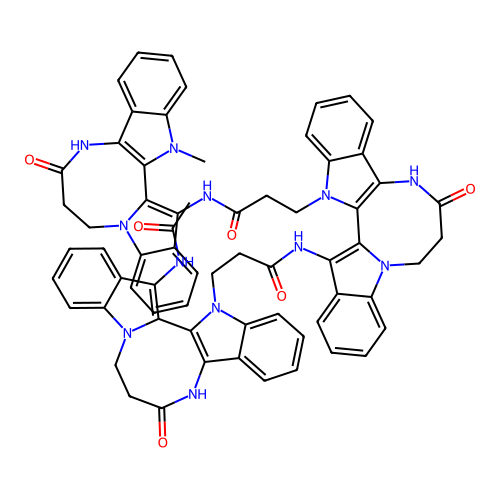

In [35]:
%%time

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img.png')
img

CPU times: user 58.9 ms, sys: 281 µs, total: 59.2 ms
Wall time: 58.4 ms


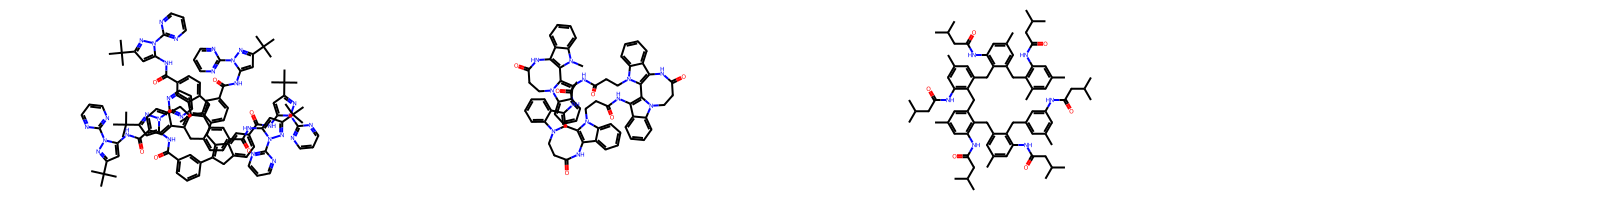

In [36]:
%%time

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [37]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  1697.077


### REFERENCES